In [1]:
import xgboost

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from statsmodels.tsa.seasonal import STL
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression


In [38]:

# Reload the dataset with the correct delimiter and sort it by date
df = pd.read_csv('data/train_egg_sales.csv', delimiter=';')
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

# Create features based on the date
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['WeekDay']   = df['Date'].dt.weekday
df['DayofYear'] = df['Date'].dt.dayofyear
df['Quarter']   = df['Date'].dt.quarter

# Drop the rows with missing values generated due to lag features
df = df.dropna()

# Show the first few rows of the enhanced dataset
df.head()


,Date,Egg Sales,Year,Month,Day,WeekDay,DayofYear,Quarter
0,1993-01-01,91,1993,1,1,4,1,1
1,1993-01-02,124,1993,1,2,5,2,1
2,1993-01-03,112,1993,1,3,6,3,1
3,1993-01-04,115,1993,1,4,0,4,1
4,1993-01-05,107,1993,1,5,1,5,1


In [57]:
a = df.groupby(['Year'])['Egg Sales'].mean()
df_new = pd.DataFrame([a.index, a.values]).T
df_new.columns=['Year','Egg Sales']

x = df_new['Year'].values.reshape(-1, 1)
y = df_new['Egg Sales'].values.reshape(-1, 1)

model1 = LinearRegression()
model1.fit(x,y)
pred1 = model1.predict(x)
print(f'MSE= {mean_squared_error(y,pred1,squared=True)}')

testx = np.array([2022.0]).reshape(-1, 1)
predT = model1.predict(testx)
predT = predT[0][0]
print(f'Prediction sales in 2022 is {predT}')

MSE= 27.399787937226744
Prediction sales in 2022 is 637.1231650624322


In [58]:
def createFeature(df):
    df['Date']      = pd.to_datetime(df['Date'])
    df['Year']      = df['Date'].dt.year
    df['Month']     = df['Date'].dt.month
    df['Day']       = df['Date'].dt.day
    df['WeekDay']   = df['Date'].dt.weekday
    df['DayofYear'] = df['Date'].dt.dayofyear
    df['Quarter']   = df['Date'].dt.quarter
    return df

In [59]:
df.groupby('Year')['Egg Sales'].transform('mean')

0        111.394521
1        111.394521
2        111.394521
3        111.394521
4        111.394521
            ...    
10587    621.260274
10588    621.260274
10589    621.260274
10590    621.260274
10591    621.260274
Name: Egg Sales, Length: 10592, dtype: float64

In [60]:
def preprocessing(df):
    x = df.copy()
    x = createFeature(df)
    if "Egg Sales" in x.columns:
        x['Mean'] = x.groupby('Year')['Egg Sales'].transform('mean')
        y = x['Egg Sales']/x['Mean']
        x = x.drop(columns=['Date','Egg Sales','Mean'])
        return x,y
    else:
        x = x.drop(columns=['Date'])
        return x

In [61]:
test = pd.read_csv("data/test_egg_sales.csv", delimiter=';')

In [62]:
x,y = preprocessing(df)
testx = preprocessing(test)

In [63]:
x

,Year,Month,Day,WeekDay,DayofYear,Quarter
0,1993,1,1,4,1,1
1,1993,1,2,5,2,1
2,1993,1,3,6,3,1
3,1993,1,4,0,4,1
4,1993,1,5,1,5,1
...,...,...,...,...,...,...
10587,2021,12,27,0,361,4
10588,2021,12,28,1,362,4
10589,2021,12,29,2,363,4
10590,2021,12,30,3,364,4


In [65]:
model2 = RandomForestRegressor()
model2.fit(x,y)
pred2 = model2.predict(x)
print(f'MSE= {mean_squared_error(y,pred2,squared=True)}')
predT2 = model2.predict(testx)

MSE= 0.0010952217558494208


In [66]:
testx.shape, final_pred.shape

((358, 6), (358,))

In [67]:
final_pred = predT*predT2

In [68]:

# # Plotting the real and predicted values
# plt.figure(figsize=(14, 7))
# plt.plot(testx.index, y_test, label='Real', color='blue')
# plt.plot(testx.index, final_pred, label='Predicted (Random Forest)', color='green')
# plt.xlabel('Index')
# plt.ylabel('Egg Sales')
# plt.title('Random Forest Forecast vs Real Data')
# plt.legend()
# plt.show()

# mse_rf


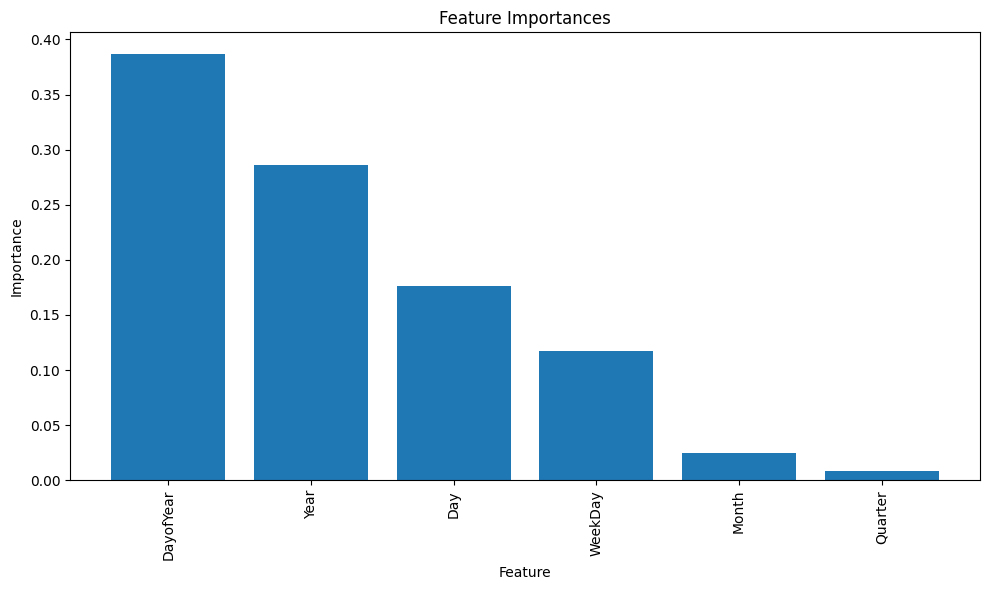

In [69]:
# Get feature importances from the RF model
importances = model2.feature_importances_
feature_names = model2.feature_names_in_
# Match feature importances with their corresponding names
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort features by importance (descending order)
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importance_df)), feature_importance_df['Importance'], tick_label=feature_importance_df['Feature'])
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.xticks(rotation=90)  # Rotate x-axis labels for better visibility

# Show the plot
plt.tight_layout()
plt.show()

In [70]:
test = pd.read_csv('data/test_egg_sales.csv', delimiter=';')
test.head()

,Date
0,2022-01-01
1,2022-01-02
2,2022-01-03
3,2022-01-04
4,2022-01-05


In [83]:
submission = pd.read_csv('data/sample_submission updated.csv', delimiter=';').columns
submission

Index(['ID', 'Expected'], dtype='object')

In [81]:
# submission['Expected'] = final_pred
test

,Date,Expected
0,2022-01-01,619.942838
1,2022-01-02,615.352081
2,2022-01-03,623.269052
3,2022-01-04,625.795433
4,2022-01-05,623.801205
...,...,...
353,2022-12-20,702.993099
354,2022-12-21,690.940109
355,2022-12-22,694.113460
356,2022-12-23,692.612198


In [84]:
test.columns = pd.read_csv('data/sample_submission updated.csv', delimiter=';').columns

In [86]:

test.to_csv("submission.csv", index=False)

In [87]:
pd.read_csv("submission.csv")

,ID,Expected
0,2022-01-01,619.942838
1,2022-01-02,615.352081
2,2022-01-03,623.269052
3,2022-01-04,625.795433
4,2022-01-05,623.801205
...,...,...
353,2022-12-20,702.993099
354,2022-12-21,690.940109
355,2022-12-22,694.113460
356,2022-12-23,692.612198


## GPT Response

In [88]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV

def createFeature(df):
    df['Date'] = pd.to_datetime(df['Date'])
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['Day'] = df['Date'].dt.day
    df['WeekDay'] = df['Date'].dt.weekday
    df['DayofYear'] = df['Date'].dt.dayofyear
    df['Quarter'] = df['Date'].dt.quarter
    return df

def preprocessing(df):
    x = df.copy()
    x = createFeature(df)
    if "Egg Sales" in x.columns:
        x['Mean'] = x.groupby('Year')['Egg Sales'].transform('mean')
        y = x['Egg Sales']/x['Mean']
        x = x.drop(columns=['Date','Egg Sales','Mean'])
        return x, y
    else:
        x = x.drop(columns=['Date'])
        return x

# Load the datasets
df = pd.read_csv('data/train_egg_sales.csv', delimiter=';')
test = pd.read_csv('data/test_egg_sales.csv', delimiter=';')

# Preprocess the data
x, y = preprocessing(df)
test_x = preprocessing(test)

# Hyperparameter tuning for RandomForestRegressor
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=RandomForestRegressor(), param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(x, y)
best_params = grid_search.best_params_

# Train the model with the best parameters
model = RandomForestRegressor(**best_params)
model.fit(x, y)

# Make predictions
preds = model.predict(test_x)



Fitting 3 folds for each of 108 candidates, totalling 324 fits


KeyError: 'Id'

[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   2.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=150; total time=   8.8s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   2.7s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   4.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=150; total time=   6.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=150; total time=   5.7s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   2.2s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   4.4s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=150; total time=   6.8s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimat

In [95]:
preds*predT

array([625.04462266, 625.16486023, 623.06766612, 622.71518679,
       623.27226626, 623.48440583, 625.3600093 , 627.49857489,
       629.11094004, 625.58450868, 625.41544891, 626.2007137 ,
       633.2819796 , 636.95300742, 638.24900526, 639.54637558,
       637.35385303, 638.20184319, 638.76201165, 636.81337396,
       637.98038858, 640.10345739, 638.26712106, 631.03207931,
       628.95525724, 622.15489168, 621.31310825, 624.26119319,
       627.6920216 , 631.49414077, 617.91521436, 619.30217229,
       621.71303496, 624.10426138, 630.43194758, 638.49195601,
       639.06727709, 618.31797653, 617.96206139, 620.68331179,
       624.35973003, 631.40932384, 635.7840464 , 636.03861556,
       617.71411448, 618.16762597, 620.8160672 , 624.57133676,
       632.86601991, 631.93681878, 631.67052761, 622.4683736 ,
       624.7508282 , 628.22519249, 637.18290186, 638.27023087,
       637.81476498, 638.50908978, 638.89305877, 640.72390055,
       642.56377994, 640.58634229, 641.45489186, 645.20

In [96]:

# Creating submission DataFrame
submission = pd.DataFrame({
    'ID': test['Date'],
    'Expected': preds*predT
})

# Save to CSV
submission.to_csv('submission.csv', index=False)

# Trying Tensorflow models

In [102]:
conda env list

ValueError: The python kernel does not appear to be a conda environment.  Please use ``%pip install`` instead.

In [97]:

import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Preprocessing functions
def createFeature(df):
    df['Date'] = pd.to_datetime(df['Date'])
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['Day'] = df['Date'].dt.day
    df['WeekDay'] = df['Date'].dt.weekday
    df['DayofYear'] = df['Date'].dt.dayofyear
    df['Quarter'] = df['Date'].dt.quarter
    return df

def preprocessing(df):
    x = df.copy()
    x = createFeature(df)
    if "Egg Sales" in x.columns:
        x['Mean'] = x.groupby('Year')['Egg Sales'].transform('mean')
        y = x['Egg Sales']/x['Mean']
        x = x.drop(columns=['Date','Egg Sales','Mean'])
        return x, y
    else:
        x = x.drop(columns=['Date'])
        return x

# Load and preprocess the data
df = pd.read_csv('data/train_egg_sales.csv', delimiter=';')
x, y = preprocessing(df)
test_x = preprocessing(pd.read_csv('data/test_egg_sales.csv', delimiter=';'))

# Standardize the data
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)
test_x_scaled = scaler.transform(test_x)

# Split the data
X_train, X_val, y_train, y_val = train_test_split(x_scaled, y, test_size=0.2, random_state=42)

# Create the model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val))

# Evaluate the model
val_loss = model.evaluate(X_val, y_val)
print(f'Validation MSE: {val_loss}')



ModuleNotFoundError: No module named 'tensorflow'

In [ ]:
# Make predictions
predictions = model.predict(test_x_scaled)

# Prepare the submission file
submission = pd.DataFrame({
    'ID': test['Date'],
    'Expected': predictions.flatten()
})

# Save the submission file
submission.to_csv('submission.csv', index=False)
